## 프로젝트 소개
플라즈마 이상 신호를 진단하기 위해 광 신호를 활용하는 센서를 개발 중입니다.

![플라즈마 이미지](image/project/plasma.jpg)

PMT 소자를 활용하여 플라즈마에서 방출된 photon을 electron으로 변환하여 세기를 측정하는 방식입니다.

데이터 형식은 1차원 배열로, 센서에서는 두 가지 형태의 데이터를 생성합니다:
1. **Streaming Data**: 초당 10,000,000 포인트를 생성합니다.
2. **Trend Data**: 초당 200 포인트를 생성하며, Streaming Data에서 최소값, 최대값, 평균을 50,000 포인트마다 샘플링하여 생성합니다.

현재 데이터의 양이 많아서 사람이 수동으로 데이터를 확인하고 있습니다.

Trend Data는 비교적 쉽게 확인할 수 있지만, Streaming Data로는 데이터 양이 많아서 사람이 수동으로 확인하기 어렵습니다.

이번 교육을 통해 머신러닝/딥러닝을 활용하여 데이터를 자동으로 분석하여 이상 신호 진단 결과를 도출하는 모델을 개발하고자 합니다.


### 센서 신호 정의

신호의 세기는 0 ~ 5 값이며, 값은 소수점 6 자리까지 나옵니다.

데이터 반출 문제로 센서 데이터를 생성해야 합니다.

trend data (200 points/s)도 만들기 어려워 (10 points/s) 데이터를 수동으로 만들었습니다.

총 7개 이며 신호는 아래와 같습니다

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_4](image/base_signal/signal_4.png)
![signal_5](image/base_signal/signal_5.png)
![signal_6](image/base_signal/signal_6.png)
![signal_7](image/base_signal/signal_7.png)

### 정상 신호의 정의

정상 신호는 다음과 같이 정의됩니다:

- **Stable한 신호**: 단계가 변경될 때를 제외하고 안정적으로 유지되는 신호입니다.

![normal](image/project/normal.png)

### 이상 신호의 정의
이상 신호는 다음과 같이 정의됩니다:

1. **Outlier 발생 지점**: 안정적인 신호에서 벗어나 이상 현상이 발생한 지점입니다.

![outlier](image/project/outlier.png)

2. **Variation이 커지는 영역**: 안정적인 신호에서 변동이 크게 나타나는 지점입니다.

![noise](image/project/noise.png)

### 특이 사항

![신호 step](image/project/signal_step.png)

위 그림과 같이 step(구간) 별로 step 시작 부분에 신호 변곡점이 생기는데 해당 부분은 잡지 말아야 합니다.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 함수 설명

- **add_outlier_signal**: 특정 구간에 이상치(outlier)를 생성하는 함수 (n개의 이상치를 추가)
- **add_noise_signal**: 정규 분포 노이즈를 생성하여 신호에 추가하는 함수 (특정 범위 내에서)

### 정상/비정상 신호 생성

기본 신호(Base Signal)를 기반으로 다음 두 가지 함수를 사용하여 정상 및 비정상 신호를 생성합니다:

1. **정상 신호 (Normal Signal)**
   - 기본 신호에 `add_noise_signal` 함수를 적용하여 생성합니다.
   - 전체 신호에 0.01%의 랜덤 노이즈를 추가합니다. (SNR=1000, Signal 1000 : Noise 1)

2. **이상치 신호 (Outlier Signal)**
   - 기본 신호에 0.01%의 랜덤 노이즈를 추가한 후, `add_outlier_signal` 함수를 적용하여 생성합니다.
   - 특정 구간에 이상치를 추가합니다.

3. **노이즈 신호 (Noise Signal)**
   - 기본 신호에 0.01%의 랜덤 노이즈를 추가한 후, `add_noise_signal` 함수를 적용하여 생성합니다.
   - 특정 구간에 정규 분포 노이즈를 추가합니다.

In [2]:
SNR = 1000

In [3]:
def generate_data(signal_func, num_samples, *args):
    data_list = []
    for _ in range(num_samples):
        val = signal_func(*args)
        data_list.append(val)
    res = np.vstack(data_list)
    return np.round(res, 6)

def make_signal_with_noise(signal):
    signal_with_noise = np.copy(signal)
    signal_with_noise += np.random.normal(scale=1/SNR, size=len(signal))
    return signal_with_noise

def add_outlier_signal(signal, outlier_ratio, range_, n_outlier=1):
    start, end = range_
    modified_signal = make_signal_with_noise(signal)
    outlier_index_list = np.random.choice(range(start, end+1), size=n_outlier, replace=False)
    for outlier_index in outlier_index_list:
        modified_signal[outlier_index] *= outlier_ratio
    return modified_signal

def add_noise_signal(signal, noise_ratio, range_):
    start, end = range_
    noisy_signal = make_signal_with_noise(signal)
    noisy_signal[start:end+1] += np.random.normal(scale=np.mean(signal)*noise_ratio, size=end-start+1)
    return noisy_signal

In [4]:
def get_original_signal():
    return {i: np.loadtxt(f'./data/raw/trend_data{i}.csv', delimiter=',') for i in range(1, 8)}

In [5]:
signal_dict = get_original_signal()

위의 기본 신호 7개 중, 다양한 신호 패턴을 다룰 수 있게 4개의 기본 신호를 선정했습니다.

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_5](image/base_signal/signal_5.png)

또한 기본 신호마다 outlier, noise 추가할 구간을 나눠주었습니다.

In [6]:
base_signal_idx = [1, 2, 3, 5]
base_signal_dict = {key: signal_dict[key] for key in base_signal_idx}
base_signal_section = {
    1: [(200, 400), (500, 700), (850, 940)],
    2: [(200, 800), (900, 950), (1030, 1080)],
    3: [(200, 500), (600, 750), (800, 900)],
    5: [(50, 200), (400, 1200), (1450, 1510)]
}

만든 함수를 이용해 신호를 생성

random으로 생성 신호를 추출하여 그래프를 그려 유효한지 확인

In [7]:
signal_idx = 1
section_idx = 0

n_normal_samples = 10000

outlier_ratio = 1.4
n_outlier = 1
n_outlier_samples = 1000

noise_ratio = 0.05
n_noise_samples = 1000

section = base_signal_section[signal_idx][section_idx]
signal = base_signal_dict[signal_idx]

normal_signal = generate_data(add_noise_signal, n_normal_samples, signal, 1/SNR, [0, len(signal)-1])
outlier_signal_array = generate_data(add_outlier_signal, n_outlier_samples, signal, outlier_ratio, section, n_outlier)
noise_signal_array = generate_data(add_noise_signal, n_noise_samples, signal, noise_ratio, section)

In [8]:
def check_signal_validity(signal, n_samples, n_cols=2):
    indices = np.random.choice(len(signal), n_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_samples//n_cols+1, n_cols, i+1)
        plt.plot(signal[idx])
        plt.title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()

normal signal (10000, 972)


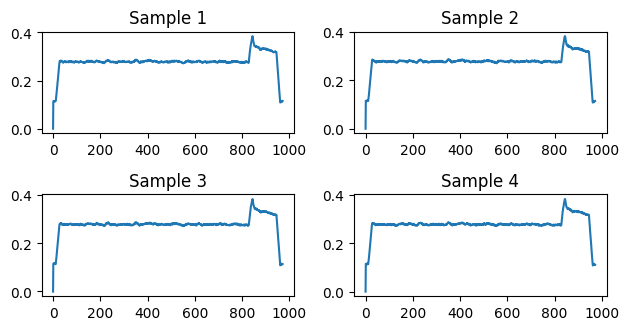

outlier signal (1000, 972)


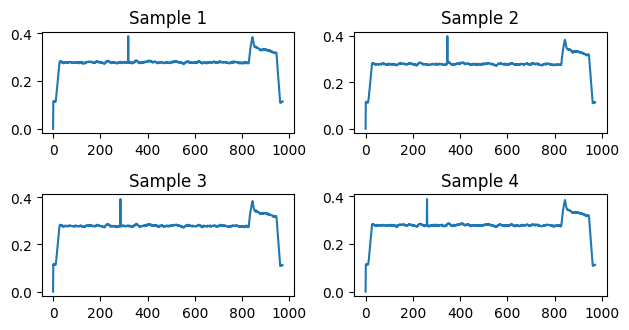

noise signal (1000, 972)


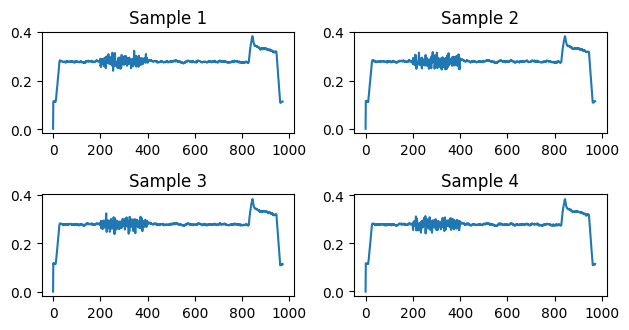

In [9]:
n_samples = 4
print('normal signal', normal_signal.shape)
check_signal_validity(normal_signal, n_samples)
print('outlier signal', outlier_signal_array.shape)
check_signal_validity(outlier_signal_array, n_samples)
print('noise signal', noise_signal_array.shape)
check_signal_validity(noise_signal_array, n_samples)

### 정상/비정상 신호 생성 기준

기본 신호 4개 기준, section은 3개로 전부 동일 (즉, 신호 1개당 3개 구간)

1. **정상 신호 (Normal Signal)**
   - 개수: 10,000 개

2. **이상치 신호 (Outlier Signal)**
   - 개수: 1,800 개 (구간 별 600 개)
   - 크기: 기존 신호의 1.4배
   - 개수: 1 point

3. **노이즈 신호 (Noise Signal)**
   - 개수: 1,800 개 (구간 별 600 개)
   - 크기: 기존 신호 + 신호 평균 * 0.05 scale을 갖는 정규분포

### Target columns 설명
1. **Target**
   - 0: 정상 신호
   - 1: 이상치 신호
   - 2: 노이즈 신호

2. **Section**
   - 구간 (순서대로 1, 2, 3)
   - base_signal_section 변수 참고

In [10]:
# data 만드는 기준 정보
n_normal_samples = 10000

outlier_ratio = 1.4
n_outlier = 1
n_outlier_samples = 600

noise_ratio = 0.05
n_noise_samples = 600

target_normal = 0

In [11]:
total_dict = {}
for signal_idx, signal in base_signal_dict.items():
    normal_signal = generate_data(add_noise_signal, n_normal_samples, signal, 1/SNR, [0, len(signal)-1])
    row_data = np.copy(normal_signal)
    
    for section in base_signal_section[signal_idx]:
        signal = signal_dict[signal_idx]

        outlier_signal_array = generate_data(add_outlier_signal, n_outlier_samples, signal, outlier_ratio, section, n_outlier)
        noise_signal_array = generate_data(add_noise_signal, n_noise_samples, signal, noise_ratio, section)
        
        row_data = np.vstack((row_data, outlier_signal_array, noise_signal_array))
    
    s = 0
    e = n_normal_samples

    df = pd.DataFrame(row_data)    
    df.loc[s:e, 'target'] = target_normal
    for i, v in enumerate(base_signal_section):
        s = e
        e = s+n_outlier_samples
        df.loc[s:e, 'target'] = i+1
        
        s = e
        e = s+n_noise_samples
        df.loc[s:e, 'target'] = i+4
        
    df['target'] = df['target'].astype(int)
    
    total_dict[signal_idx] = df

pd.crosstab 이용, 개수 확인 결과 완료 (아래 코드 및 사진)

정상 신호: 10,000 개, 이상치 신호: 1,800 개 (구간 별 600 개), 노이즈 신호: 1,800 개 (구간 별 600 개)

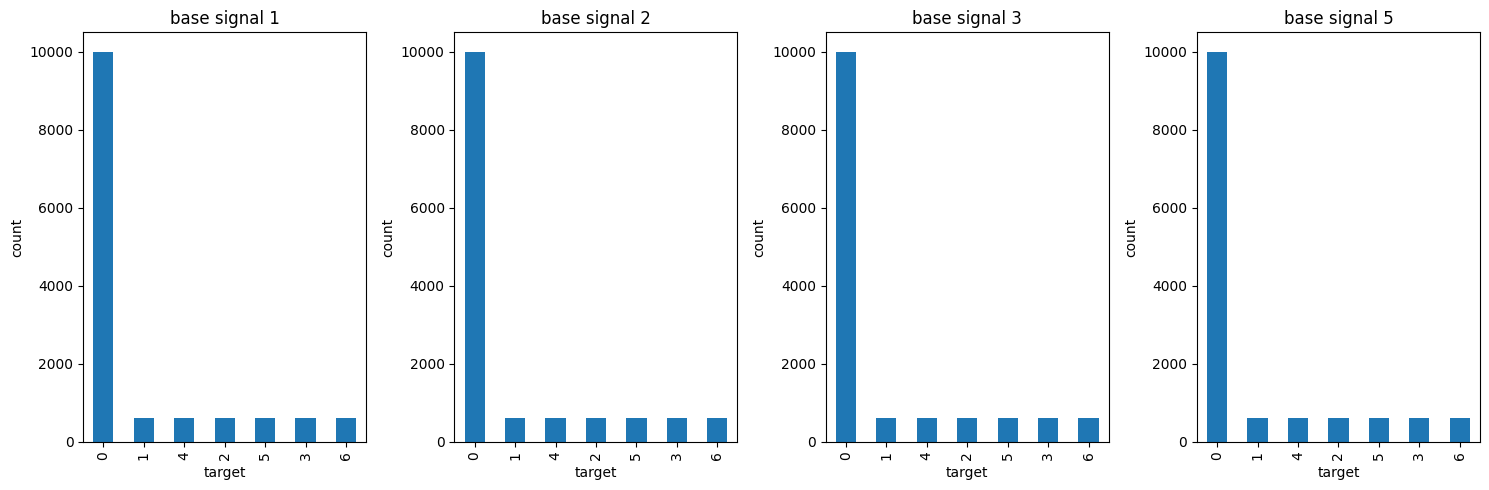

In [12]:
plt.figure(figsize=(15, 5))
for i, (key, value) in enumerate(total_dict.items(), start=1):
    plt.subplot(1, len(total_dict), i)
    
    x = total_dict[1]['target'].value_counts().index
    y = total_dict[1]['target'].value_counts().values
    total_dict[1]['target'].value_counts().plot(kind='bar', stacked=True, ax=plt.gca())
    
    plt.title(f'base signal {key}')
    plt.xlabel('target')
    plt.ylabel('count')
plt.tight_layout()
plt.show()

아래 np.random.choice를 이용해서 한 번에 9개씩 여러 번 돌려 확인 결과 잘 만들어졌음을 확인 완료

data_1, data_2, data_3, data_5 이름의 csv 포맷으로 저장

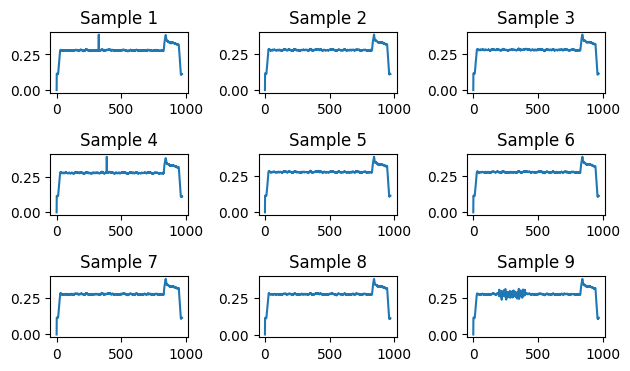

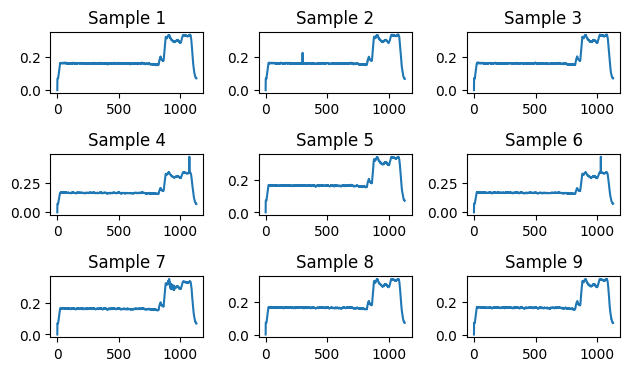

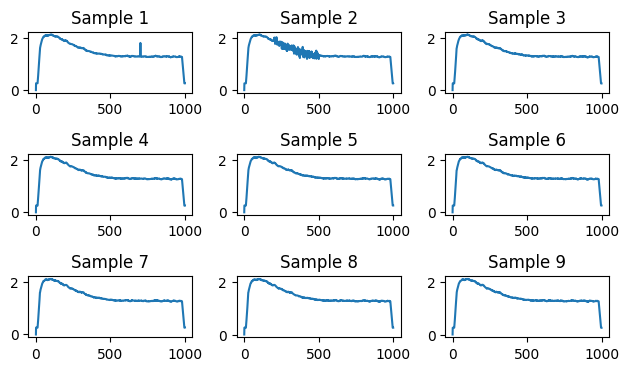

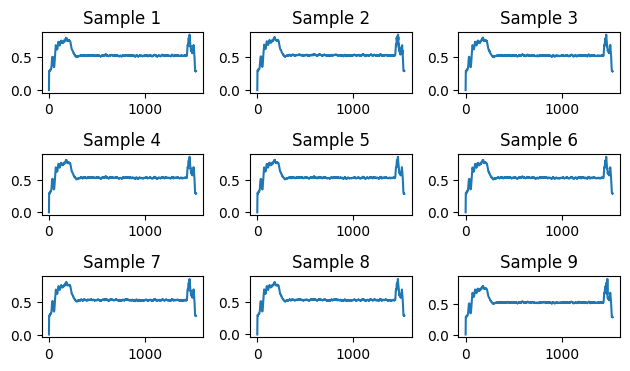

In [13]:
for signal_idx in base_signal_idx:
    arr = np.array(total_dict[signal_idx].iloc[:,:-2])
    check_signal_validity(arr, 9, 3)

In [14]:
if not os.path.exists("./data/signal/data_1.csv"):
    for key, value in total_dict.items():
        filename = f"./data/signal/data_{key}.csv"
        value.to_csv(filename, index=False)

# 데이터

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_5](image/base_signal/signal_5.png)

파이프라인

In [15]:
def pipeline(X, y):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error

    # 트레이닝 / 테스트 데이터 분할
    X_tn, X_te, y_tn, y_te = train_test_split(X,y,random_state=7)

    # 표준화 스케일링
    std_scale = StandardScaler()
    X_tn_std = std_scale.fit_transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 학습
    clf_linear =  LinearRegression()
    clf_linear.fit(X_tn_std, y_tn)

    # 예측
    pred_linear = clf_linear.predict(X_te_std)

    # 평가
    print(mean_squared_error(y_te, pred_linear))

    # 트레이닝 / 테스트 데이터 분할
    X_tn, X_te, y_tn, y_te = train_test_split(X,y,random_state=7)

    # 파이프라인
    linear_pipline = Pipeline([
        ('scaler',StandardScaler()), 
        ('linear_regression', LinearRegression()) 
    ])

    # 학습
    linear_pipline.fit(X_tn, y_tn)

    # 예측
    pred_linear = linear_pipline.predict(X_te)

    # 평가
    print(mean_squared_error(y_te, pred_linear))

그리드 서치

In [16]:
def grid_search(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝 / 테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 표준화 스케일
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    best_accuracy = 0

    for k in [1,2,3,4,5,6,7,8,9,10]:
        clf_knn =  KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(X_tn_std, y_tn)
        knn_pred = clf_knn.predict(X_te_std)
        accuracy = accuracy_score(y_te, knn_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            final_k = {'k': k}
        
    print(final_k)
    print(accuracy)

k최근접이웃

In [17]:
def k_neighbors(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝 / 테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 표준화 스케일
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    #학습
    clf_knn =  KNeighborsClassifier(n_neighbors=2)
    clf_knn.fit(X_tn_std, y_tn)

    # 예측
    knn_pred = clf_knn.predict(X_te_std)
    print(knn_pred)

    # 정확도
    accuracy = accuracy_score(y_te, knn_pred)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, knn_pred)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, knn_pred)
    print(class_report)

선형회귀분석

In [18]:
def linear_regression(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    from sklearn.linear_model import Ridge
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import ElasticNet
    from sklearn.linear_model import LinearRegression 

    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error


    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te = train_test_split(X,y,random_state=1)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 선형 회귀분석 학습
    clf_lr =  LinearRegression()
    clf_lr.fit(X_tn_std, y_tn)

    # 선형 회귀분석 모형 추정 계수 확인
    print(clf_lr.coef_)
    print(clf_lr.intercept_)

    # 릿지 회귀분석(L2 제약식 적용)
    clf_ridge = Ridge(alpha=1)
    clf_ridge.fit(X_tn_std, y_tn)

    # 릿지 회귀분석 모형 추정 계수 확인
    print(clf_ridge.coef_)
    print(clf_ridge.intercept_)

    # 라쏘 회귀분석(L1 제약식 적용)
    clf_lasso = Lasso(alpha=0.01)
    clf_lasso.fit(X_tn_std, y_tn)

    # 라쏘 회귀분석 모형 추정 계수 확인
    print(clf_lasso.coef_)
    print(clf_lasso.intercept_)

    # 엘라스틱넷
    clf_elastic = ElasticNet(alpha=0.01, l1_ratio=0.01)
    clf_elastic.fit(X_tn_std, y_tn)

    # 엘라스틱넷 모형 추정 계수 확인
    print(clf_elastic.coef_)
    print(clf_elastic.intercept_)

    # 예측
    pred_lr = clf_lr.predict(X_te_std)
    pred_ridge = clf_ridge.predict(X_te_std)
    pred_lasso = clf_lasso.predict(X_te_std)
    pred_elastic = clf_elastic.predict(X_te_std)

    # 모형 평가-R제곱값
    print(r2_score(y_te, pred_lr))
    print(r2_score(y_te, pred_ridge))
    print(r2_score(y_te, pred_lasso))
    print(r2_score(y_te, pred_elastic))

    # 모형 평가-MSE
    print(mean_squared_error(y_te, pred_lr))
    print(mean_squared_error(y_te, pred_ridge))
    print(mean_squared_error(y_te, pred_lasso))
    print(mean_squared_error(y_te, pred_elastic))

로지스틱회귀분석

In [19]:
def logistic_regression(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    from sklearn.linear_model import LogisticRegression

    from sklearn.metrics import precision_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 로지스틱 회귀분석(L2 제약식 적용)
    clf_logi_l2 = LogisticRegression(penalty='l2')
    clf_logi_l2.fit(X_tn_std, y_tn)

    # 로지스틱 회귀분석 모형(L2 제약식 적용) 추정 계수
    print(clf_logi_l2.coef_)
    print(clf_logi_l2.intercept_)

    # 예측
    pred_logistic = clf_logi_l2.predict(X_te_std)
    print(pred_logistic)

    # 확률값으로 예측
    pred_proba = clf_logi_l2.predict_proba(X_te_std)
    print(pred_proba)

    # 정밀도
    precision = precision_score(y_te, pred_logistic, average='micro')
    print(precision)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_logistic)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_logistic)
    print(class_report)

나이브 베이즈

In [20]:
def naive_bayes(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    from sklearn.naive_bayes import GaussianNB

    from sklearn.metrics import recall_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 나이브 베이즈 학습
    clf_gnb = GaussianNB()
    clf_gnb.fit(X_tn_std, y_tn)

    # 예측
    pred_gnb = clf_gnb.predict(X_te_std)
    print(pred_gnb)

    # 리콜
    recall = recall_score(y_te, pred_gnb, average='macro')
    print(recall)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_gnb)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_gnb)
    print(class_report)

의사결정나무

In [21]:
def decision_tree(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    from sklearn import tree 

    from sklearn.metrics import f1_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report


    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 의사결정나무 학습
    clf_tree = tree.DecisionTreeClassifier(random_state=0)
    clf_tree.fit(X_tn_std, y_tn)

    # 예측
    pred_tree = clf_tree.predict(X_te_std)
    print(pred_tree)

    # f1 score
    f1 = f1_score(y_te, pred_tree, average='macro')
    print(f1)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_tree)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_tree)
    print(class_report)

서포트벡터머신

In [22]:
def support_vector_machine(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    from sklearn import svm 

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 서포트벡터머신 학습
    clf_svm_lr = svm.SVC(kernel='linear', random_state=0)
    clf_svm_lr.fit(X_tn_std, y_tn)

    # 예측
    pred_svm = clf_svm_lr.predict(X_te_std)
    print(pred_svm)

    # 정확도
    accuracy = accuracy_score(y_te, pred_svm)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_svm)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_svm)
    print(class_report)

크로스밸리데이션

In [23]:
def cross_validation(X, y):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    from sklearn import svm 
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import GridSearchCV

    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import cross_val_score

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 그리드 서치 학습
    param_grid= {'kernel': ('linear', 'rbf'), 'C': [0.5, 1, 10, 100]}
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    svc = svm.SVC(random_state=0)
    grid_cv = GridSearchCV(svc, param_grid, cv=kfold, scoring='accuracy')
    grid_cv.fit(X_tn_std, y_tn)

    # 그리드 서치 결과 확인
    print(grid_cv.cv_results_)
    np.transpose(pd.DataFrame(grid_cv.cv_results_))

    # 베스트 스코어
    grid_cv.best_score_

    # 베스트 하이퍼파라미터
    grid_cv.best_params_

    # 최종 모형
    clf = grid_cv.best_estimator_
    print(clf)

    # 크로스 밸리데이션 스코어 확인(1)
    metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    cv_scores = cross_validate(clf, X_tn_std, y_tn, cv=kfold, scoring=metrics)

    # 크로스 밸리데이션 스코어 확인(2)
    cv_score = cross_val_score(clf, X_tn_std, y_tn, cv=kfold, scoring='accuracy')
    print(cv_score)
    print(cv_score.mean())
    print(cv_score.std())

    # 예측
    pred_svm = clf.predict(X_te_std)
    print(pred_svm)

    # 정확도
    accuracy = accuracy_score(y_te, pred_svm)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_svm)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_svm)
    print(class_report)

보팅

In [24]:
def voting(X, y):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    from sklearn.linear_model import LogisticRegression
    from sklearn import svm
    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import VotingClassifier

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 보팅 학습
    clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
    clf2 = svm.SVC(kernel='linear', random_state=1) 
    clf3 = GaussianNB()

    clf_voting = VotingClassifier(
                    estimators=[
                        ('lr', clf1), 
                        ('svm', clf2), 
                        ('gnb', clf3)
                    ],
                    voting='hard',
                    weights=[1,1,1])
    clf_voting.fit(X_tn_std, y_tn)

    # 예측
    pred_voting = clf_voting.predict(X_te_std)
    print(pred_voting)

    # 정확도
    accuracy = accuracy_score(y_te, pred_voting)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_voting)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_voting)
    print(class_report)

랜덤포레스트

In [25]:
def random_forest(X, y):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    from sklearn.ensemble import RandomForestClassifier

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 랜덤포레스트 학습
    clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
    clf_rf.fit(X_tn_std, y_tn)

    # 예측
    pred_rf = clf_rf.predict(X_te_std)
    print(pred_rf)

    # 정확도
    accuracy = accuracy_score(y_te, pred_rf)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_rf)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_rf)
    print(class_report)

배깅

In [26]:
def bagging(X, y):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import BaggingClassifier

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 배깅 학습
    clf_bagging = BaggingClassifier(estimator=GaussianNB(), n_estimators=10, random_state=0)
    clf_bagging.fit(X_tn_std, y_tn)

    # 예측
    pred_bagging = clf_bagging.predict(X_te_std)
    print(pred_bagging)

    # 정확도
    accuracy = accuracy_score(y_te, pred_bagging)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_bagging)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_bagging)
    print(class_report)

adaboost

In [27]:
def adaboost(X, y):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    from sklearn.ensemble import AdaBoostClassifier

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 에이다 부스트 학습
    clf_ada = AdaBoostClassifier(random_state=0)
    clf_ada.fit(X_tn_std, y_tn)

    # 예측
    pred_ada = clf_ada.predict(X_te_std)
    print(pred_ada)

    # 정확도
    accuracy = accuracy_score(y_te, pred_ada)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_ada)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_ada)
    print(class_report)

gradientboost

In [28]:
def gradient_boost(X, y):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    from sklearn.ensemble import GradientBoostingClassifier

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # Gradient Boosting 학습
    clf_gbt = GradientBoostingClassifier(max_depth=2, 
                                        learning_rate=0.01,
                                        random_state=0)
    clf_gbt.fit(X_tn_std, y_tn)

    # 예측
    pred_gboost = clf_gbt.predict(X_te_std)
    print(pred_gboost)

    # 정확도
    accuracy = accuracy_score(y_te, pred_gboost)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_gboost)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_gboost)
    print(class_report)

스태깅

In [29]:
def stacking(X, y):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    from sklearn import svm
    from sklearn.naive_bayes import GaussianNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import StackingClassifier

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    # 트레이닝/테스트 데이터 분할
    X_tn, X_te, y_tn, y_te=train_test_split(X,y,random_state=0)

    # 데이터 표준화
    std_scale = StandardScaler()
    std_scale.fit(X_tn)
    X_tn_std = std_scale.transform(X_tn)
    X_te_std  = std_scale.transform(X_te)

    # 스태킹 학습
    clf1 = svm.SVC(kernel='linear', random_state=1) 
    clf2 = GaussianNB()

    clf_stkg = StackingClassifier(
                estimators=[
                    ('svm', clf1), 
                    ('gnb', clf2)
                ],
                final_estimator=LogisticRegression())
    clf_stkg.fit(X_tn_std, y_tn)

    # 예측
    pred_stkg = clf_stkg.predict(X_te_std)
    print(pred_stkg)

    # 정확도
    accuracy = accuracy_score(y_te, pred_stkg)
    print(accuracy)

    # confusion matrix 확인 
    conf_matrix = confusion_matrix(y_te, pred_stkg)
    print(conf_matrix)

    # 분류 레포트 확인
    class_report = classification_report(y_te, pred_stkg)
    print(class_report)

주성분분석

커널PCA

LDA

LLE

비음수행렬분해

k평균클러스터링

계층군집

DBSCAN

가우시안혼합모델

CNN

RNN

오토인코더

GAN

In [30]:
data = total_dict[base_signal_idx[0]]
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# 함수 리스트 생성
functions = [pipeline, grid_search, k_neighbors, linear_regression, logistic_regression,
             naive_bayes, decision_tree, support_vector_machine, cross_validation, voting,
             random_forest, bagging, adaboost, gradient_boost, stacking]

import time

for func in functions[:5]:
    start_time = time.time()
    print(f"{func.__name__} start")  # 함수 이름 출력
    func(X, y)
    print(f"{func.__name__} elapsed time: {time.time()-start_time:.3f} 초")
    print()